### importing data from [PennyLane](https://pennylane.ai/qml/demos/tutorial_quanvolution/)

In [ ]:
!pip install pennylane
!pip install tensorflow

In [ ]:
# use cmd prompt, pip install tensorflow and pennylane first
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 150    # Size of the train dataset
n_test = 30     # Size of the test dataset

# original [30 , 1 , 100, 30 ]
# new model -> increased epochs to see if bigger improvements can be made
# doubled train and test images to see if more samples will signiicantly improve performance.

#modded to wd
#SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
# SAVE_PATH = "/content/_static/demonstration_assets/quanvolution"
SAVE_PATH = "/content/"

PREPROCESS = False     # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)     # Seed for NumPy random number generator
tf.random.set_seed(0) # Seed for TensorFlow random number generator

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

print(type(train_images))
# Reduce dataset size

def filter_labels(images, labels, interested_labels=[0, 6]):
    mask = np.isin(labels, interested_labels)
    return images[mask], labels[mask]

# Apply filter
#train_images_filtered, train_labels_filtered = filter_labels(train_images, train_labels)
#test_images_filtered, test_labels_filtered = filter_labels(test_images, test_labels)

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]



# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False) # note, requies_grad : BOOL = False is an adaptation of numpy made by pennylane.
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)   # normal numpy and numpy autograd both dont have this.

<class 'numpy.ndarray'>


In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))
@qml.qnode(dev)
def circuit(phi):
    # print(type(phi), phi)
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    # return [qml.expval(qml.PauliZ(j)) for j in range(4)]
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    #tensor Z Dimension, wanna see if this changes the number of filters used
    zten = 4
    # zten = 5
    out = np.zeros((14, 14, zten)) # creates a tensor of 14 x 14 x 4 (xyz) # self: adding 1 more z

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(zten):
                out[j // 2, k // 2, c] = q_results[c]
    return out

refer to image and sauce for what random layers function from QML decorator does, haiz: ([sauce](https://docs.pennylane.ai/en/stable/code/api/pennylane.RandomLayers.html)), basically they really RNG the gate and the rotations

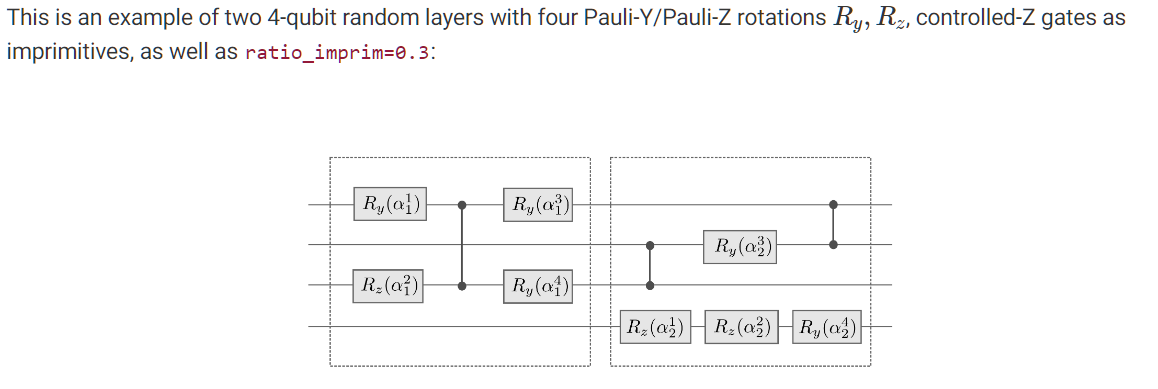

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print(f"{idx + 1}/{n_train}", end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images  = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print(f"{idx + 1}/{n_test}", end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    # modded here, savepath edited to current file

    np.save(SAVE_PATH + "q_train_images_210324.npy", q_train_images)
    np.save(SAVE_PATH +  "q_test_images_210324.npy",  q_test_images)

else:
    # Load pre-processed images

    q_train_images = np.load(SAVE_PATH + "q_train_images_210324.npy")
    q_test_images  = np.load(SAVE_PATH +  "q_test_images_210324.npy")
    # other path to use is q_train_images_210324.npy and q_test_images_210324.npy

100 test samples, ave freq of 10 per label

In [ ]:
train_labels

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2,
       9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4,
       5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3], dtype=uint8)

# The actual work: analysing filters

filter out relevant values (funtion)

In [ ]:
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]


def get_data(num,images,labels):
  thing1,thing2 = [],[]
  if type(num) == str:
    for i in range(len(images)):
      if labels[i] == num:
        thing1.append(test_images[i])
        thing2.append(test_labels[i])
  elif type(num) == list:
    for i in range(len(images)):
      if labels[i] in num:
        thing1.append(test_images[i])
        thing2.append(test_labels[i])

  return thing1,thing2

F_Images, F_Labels = get_data([0,6],test_images,test_labels)

check to see if first 10 samples are 1s and 7s

^ failed, not trained, need to redo

In [ ]:
len(q_train_images)

150

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

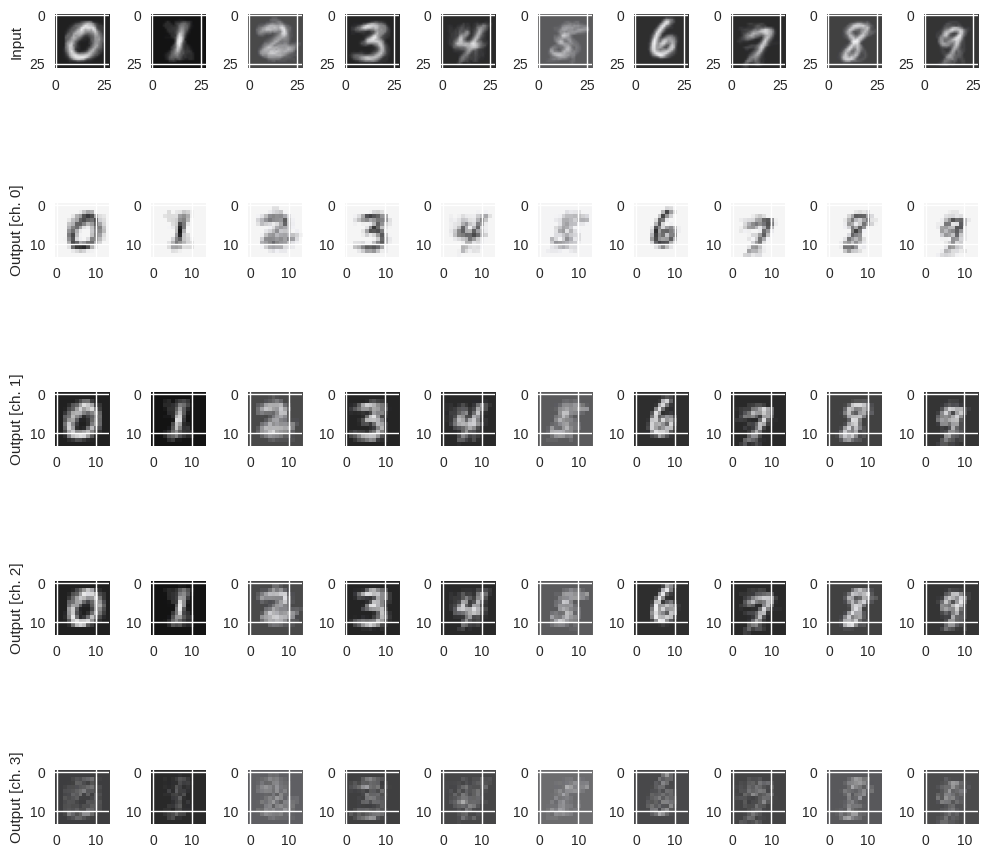

In [ ]:
n_labels = 10
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_labels, figsize=(10, 10))

for k in range(len(train_images)):
    number = train_labels[k]
    axes[0, 0].set_ylabel("Input")
    axes[0, number].imshow(train_images[k, :, :, 0], cmap="gray",alpha=0.1)
    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel(f"Output [ch. {c}]")
        axes[c + 1, number].imshow(q_train_images[k, :, :, c], cmap="gray",alpha=0.1)

plt.tight_layout()
plt.show()

## Classial training model

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
38/38 - 1s - loss: 2.1838 - accuracy: 0.2733 - val_loss: 1.6090 - val_accuracy: 0.4667 - 1s/epoch - 38ms/step
Epoch 2/30
38/38 - 0s - loss: 1.3928 - accuracy: 0.6067 - val_loss: 1.2614 - val_accuracy: 0.6333 - 322ms/epoch - 8ms/step
Epoch 3/30
38/38 - 0s - loss: 0.9976 - accuracy: 0.7200 - val_loss: 1.1695 - val_accuracy: 0.6000 - 235ms/epoch - 6ms/step
Epoch 4/30
38/38 - 0s - loss: 0.7090 - accuracy: 0.8200 - val_loss: 0.9196 - val_accuracy: 0.7333 - 204ms/epoch - 5ms/step
Epoch 5/30
38/38 - 0s - loss: 0.5570 - accuracy: 0.9067 - val_loss: 0.9002 - val_accuracy: 0.7333 - 394ms/epoch - 10ms/step
Epoch 6/30
38/38 - 0s - loss: 0.4555 - accuracy: 0.9333 - val_loss: 0.8439 - val_accuracy: 0.7000 - 260ms/epoch - 7ms/step
Epoch 7/30
38/38 - 0s - loss: 0.3824 - accuracy: 0.9400 - val_loss: 0.7695 - val_accuracy: 0.7667 - 280ms/epoch - 7ms/step
Epoch 8/30
38/38 - 0s - loss: 0.3069 - accuracy: 0.9667 - val_loss: 0.8147 - val_accuracy: 0.8000 - 347ms/epoch - 9ms/step
Epoch 9/30
38/38 

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
38/38 - 2s - loss: 2.1497 - accuracy: 0.2733 - val_loss: 1.7595 - val_accuracy: 0.6000 - 2s/epoch - 54ms/step
Epoch 2/30
38/38 - 0s - loss: 1.4323 - accuracy: 0.6867 - val_loss: 1.4083 - val_accuracy: 0.7333 - 338ms/epoch - 9ms/step
Epoch 3/30
38/38 - 1s - loss: 1.0677 - accuracy: 0.8400 - val_loss: 1.2110 - val_accuracy: 0.8000 - 583ms/epoch - 15ms/step
Epoch 4/30
38/38 - 0s - loss: 0.8370 - accuracy: 0.9067 - val_loss: 1.0976 - val_accuracy: 0.8000 - 348ms/epoch - 9ms/step
Epoch 5/30
38/38 - 0s - loss: 0.6777 - accuracy: 0.9133 - val_loss: 0.9864 - val_accuracy: 0.8000 - 312ms/epoch - 8ms/step
Epoch 6/30
38/38 - 0s - loss: 0.5702 - accuracy: 0.9333 - val_loss: 0.9271 - val_accuracy: 0.8000 - 183ms/epoch - 5ms/step
Epoch 7/30
38/38 - 0s - loss: 0.4895 - accuracy: 0.9467 - val_loss: 0.8937 - val_accuracy: 0.7667 - 181ms/epoch - 5ms/step
Epoch 8/30
38/38 - 0s - loss: 0.4205 - accuracy: 0.9600 - val_loss: 0.8563 - val_accuracy: 0.8333 - 201ms/epoch - 5ms/step
Epoch 9/30
38/38 

<ipython-input-45-c0d2897d0ee1>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


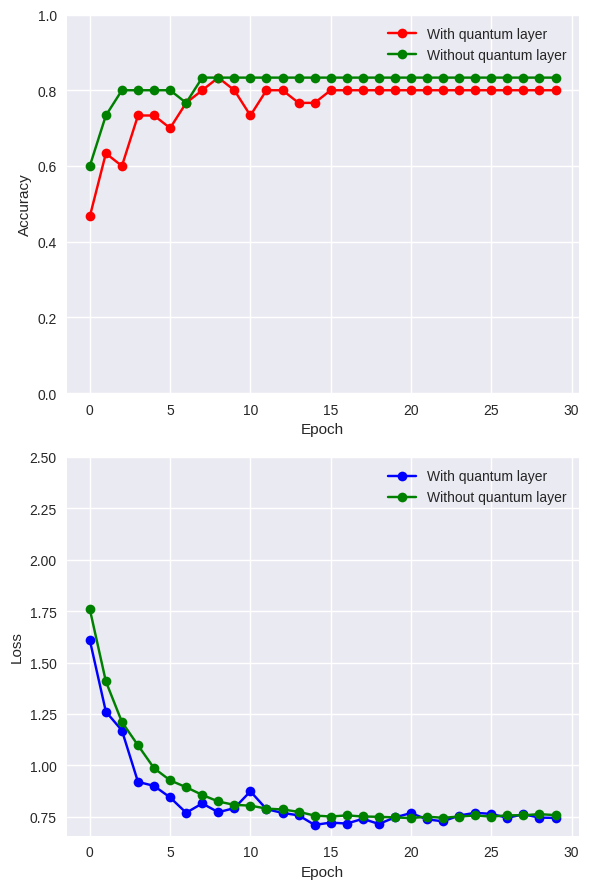

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-or", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

## Clustering to find if images can be seperated properly

 - Get a





In [ ]:
!pip install scikit-learn

1. Cluster the convolved images obtained. One with using PCA and one without. Compare and label.

In [ ]:
from sklearn.cluster import KMeans

q_train_images = np.load(SAVE_PATH + "q_train_images_210324.npy")
Model1 = KMeans(n_init = 10)
np.shape(q_train_images[0])



(14, 14, 4)

In [ ]:
q_train_images_flat = q_train_images.reshape((q_train_images.shape[0], -1))
Model1.fit(q_train_images_flat)

KMeans(n_init=10)

In [ ]:
cluster_labels = Model1.labels_
print(cluster_labels)

[2 4 0 5 0 0 7 2 7 3 2 5 2 1 7 3 0 5 1 3 0 4 3 5 7 2 0 2 2 5 0 5 1 3 4 3 1
 4 0 1 7 5 7 7 0 0 5 5 7 2 7 4 0 5 0 5 6 3 0 5 0 5 1 4 1 5 1 5 6 4 7 3 7 1
 2 4 5 5 5 3 6 4 4 1 0 5 7 3 6 3 1 3 0 1 5 4 7 5 2 5 7 3 7 3 7 5 1 2 6 0 0
 2 7 5 6 3 0 2 6 4 2 6 5 3 7 5 1 3 7 1 2 3 7 7 0 2 2 5 6 3 7 3 0 0 5 5 5 1
 0 2]


Finding the clustering properties of the original file

In [ ]:
Model2 = KMeans(n_init = 10)
train_images_flat = train_images.reshape((train_images.shape[0], -1))

Model2.fit(train_images_flat)
cluster_labels2 = Model2.labels_
print(cluster_labels2)
print()
print(train_labels)





[5 2 0 1 0 7 6 4 6 0 5 1 5 3 6 7 7 4 3 7 0 2 7 1 3 4 0 5 5 1 6 4 3 7 2 1 3
 2 7 3 6 4 7 7 5 0 5 0 5 4 5 2 7 1 0 4 2 7 0 1 0 1 3 2 0 1 3 1 5 2 6 7 6 3
 5 2 5 1 1 7 3 2 3 3 7 4 5 7 2 0 3 7 0 3 4 2 7 4 5 1 0 7 6 7 6 1 3 4 5 6 0
 5 6 1 2 0 0 4 2 2 5 2 1 7 6 4 3 0 6 3 5 0 6 7 5 4 5 4 3 0 7 1 0 1 5 1 4 3
 7 5]

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0 4 5 6 1 0 0 1 7 1 6
 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9
 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4 1 6 3 4 5 9 1 3 3 8 5 4 7 7 4 2 8 5 8 6
 7 3]


In [ ]:
#function which returns the most common assignment for each true label after Kmeans

def clusterCompare(true_labels, cluster_labels):
  result_dicts = {}
  for i in range(len(true_labels)):
    if(true_labels[i] not in result_dicts):
      result_dicts[true_labels[i]] = [cluster_labels[i]]
    else:
      result_dicts[true_labels[i]].append(cluster_labels[i])

  result_dicts = {k: result_dicts[k] for k in sorted(result_dicts.keys())}

  return result_dicts

In [ ]:
evaluateModel1 = clusterCompare(train_labels, cluster_labels)
evaluateModel2 = clusterCompare(train_labels, cluster_labels2)

for key in evaluateModel1.keys():
  print(key, ": ", evaluateModel1[key])


print("Model 2, using classical encoding")
for key in evaluateModel2.keys():
  print(key, ": ", evaluateModel2[key])


0 :  [4, 4, 4, 4, 4, 6, 4, 6, 4, 4, 4, 6, 4, 6, 6, 6, 4, 6]
1 :  [5, 7, 7, 7, 5, 7, 7, 5, 5, 7, 7, 5, 5, 5, 7, 7, 5, 7, 5, 7, 7, 0]
2 :  [0, 0, 2, 2, 5, 4, 0, 2, 2, 5, 0]
3 :  [2, 2, 2, 2, 0, 0, 2, 7, 2, 7, 2, 2, 2, 2, 2, 2, 2]
4 :  [0, 3, 0, 0, 5, 0, 0, 5, 1, 3, 0, 3, 3, 3, 3, 0]
5 :  [2, 5, 3, 5, 5, 7, 7, 6, 5]
6 :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
7 :  [3, 5, 0, 7, 0, 3, 3, 0, 3, 7, 3, 3, 3, 7, 3, 0]
8 :  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
9 :  [0, 3, 3, 3, 7, 0, 7, 0, 3, 6, 3, 0, 0, 7]
Model 2, using classical encoding
0 :  [2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2]
1 :  [1, 6, 6, 6, 1, 3, 6, 1, 1, 6, 6, 1, 1, 1, 6, 6, 1, 6, 1, 6, 6, 5]
2 :  [7, 7, 4, 5, 5, 3, 6, 4, 5, 1, 1]
3 :  [4, 5, 5, 5, 6, 5, 4, 5, 5, 5, 5, 4, 5, 5, 4, 5, 5]
4 :  [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
5 :  [5, 1, 1, 0, 1, 0, 6, 3, 1]
6 :  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
7 :  [7, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7]
8 :  [4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 

swap with mode to check actual value: if many 2s it means that 2 should be a 0


In [ ]:
from statistics import mode
#return the mode of each array. The mode should be the true image
def returnModeInDict(inDict):
  result_dict = {}
  for i in inDict.keys():
    result_dict[i] = mode(inDict[i])
  return result_dict

def swapKeyVal(input_dict):
    # Create a new dictionary to store swapped key-value pairs
    swapped_dict = {v: k for k, v in input_dict.items()}
    return swapped_dict


def display_array(array):
    # Create a figure and axis
    fig, ax = plt.subplots(14, 14)

    # Iterate through the array
    for i in range(14):
        for j in range(14):
            # Get the color channels from the array
            red = array[i, j, 0]
            green = array[i, j, 1]
            blue = array[i, j, 2]
            alpha = array[i, j, 3]

            # Normalize alpha value to be between 0 and 1

            # Set the color of the pixel
            color = (red / 255.0, green / 255.0, blue / 255.0, alpha)

            # Draw the pixel on the axis
            ax[i, j].set_facecolor(color)

            # Remove ticks
            ax[i, j].axis('off')

    # Show the plot
    plt.show()

# Example usage




In [ ]:
interpretedVal1 = swapKeyVal(returnModeInDict(evaluateModel1))
interpretedVal2 = swapKeyVal(returnModeInDict(evaluateModel2))

In [ ]:
for i in range(len())